1.**Problem statement**:

* Develop a reinforcement learning agent using dynamic programming to solve the Treasure Hunt problem in a FrozenLake environment. The agent must learn the optimal policy for navigating the lake while avoiding holes and maximizing its treasure collection.

2.**Scenario**:
* A treasure hunter is navigating a slippery 5x5 FrozenLake grid. The objective is to navigate through the lake collecting treasures while avoiding holes and ultimately reaching the exit (goal).
Grid positions on a 5x5 map with tiles labeled as S, F, H, G, T. The state includes the current position of the agent and whether treasures have been collected.


#### Objective
* The agent must learn the optimal policy π* using dynamic programming to maximize its cumulative reward while navigating the lake.

#### About the environment

The environment consists of several types of tiles:
* Start (S): The initial position of the agent, safe to step.
* Frozen Tiles (F): Frozen surface, safe to step.
* Hole (H): Falling into a hole ends the game immediately (die, end).
* Goal (G): Exit point; reaching here ends the game successfully (safe, end).
* Treasure Tiles (T): Added to the environment. Stepping on these tiles awards +5 reward but does not end the game.

After stepping on a treasure tile, it becomes a frozen tile (F).
The agent earns rewards as follows:
* Reaching the goal (G): +10 reward.
* Falling into a hole (H): -10 reward.
* Collecting a treasure (T): +5 reward.
* Stepping on a frozen tile (F): 0 reward.

#### States
* Current position of the agent (row, column).
* A boolean flag (or equivalent) for whether each treasure has been collected.

#### Actions
* Four possible moves: up, down, left, right

#### Rewards
* Goal (G): +10.
* Treasure (T): +5 per treasure.
* Hole (H): -10.
* Frozen tiles (F): 0.

#### Environment
Modify the FrozenLake environment in OpenAI Gym to include treasures (T) at certain positions. Inherit the original FrozenLakeEnv and modify the reset and step methods accordingly.
Example grid:

![image.png](attachment:image.png)


**Expected Outcomes:**
1.	Create the custom environment by modifying the existing “FrozenLakeNotSlippery-v0” in OpenAI Gym and Implement the dynamic programming using value iteration and policy improvement to learn the optimal policy for the Treasure Hunt problem.
2.	Calculate the state-value function (V*) for each state on the map after learning the optimal policy.
3.	Compare the agent’s performance with and without treasures, discussing the trade-offs in reward maximization.
4.	Visualize the agent’s direction on the map using the learned policy.
5.	Calculate expected total reward over multiple episodes to evaluate performance.

### Import required libraries and Define the custom environment - 2 Marks

In [1]:
# Import statements
import gym
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import FrozenLakeEnv

In [ ]:
# Custom environment to create the given grid and respective functions that are required for the problem

#Include functions to take an action, get reward, to check if episode is over

In [2]:

# Modify the FrozenLake environment to include treasure tiles
class TreasureHuntEnv(FrozenLakeEnv):
    def __init__(self):
        # Define a custom 5x5 map with the grid
        desc = [
            "SFFHT",
            "FHFFF",
            "FFFTH",
            "TFFHF",
            "FFFFG",
        ]
        super(TreasureHuntEnv, self).__init__(desc=desc, is_slippery=False)

        self.grid = [
            ['S', 'F', 'F', 'H', 'T'],
            ['F', 'H', 'F', 'F', 'F'],
            ['F', 'F', 'F', 'T', 'F'],
            ['T', 'F', 'H', 'F', 'F'],
            ['F', 'F', 'F', 'F', 'G']
        ]
        self.treasure_positions = [(0, 4), (2, 3), (3, 0)]
        self.agent_position = (0, 0)
        self.treasures_collected = 0
        self.done = False
        self.reward = 0
        self.actions = [0, 1, 2, 3]  # up, down, left, right
        self.P = self._build_transition_model()

    def _build_transition_model(self):
        P = {s: {a: [] for a in self.actions} for s in range(25)}

        for row in range(5):
            for col in range(5):
                state = row * 5 + col
                for action in self.actions:
                    next_state, reward, done = self._take_action((row, col), action)
                    P[state][action] = [(1.0, next_state, reward, done)]

        return P

    def reset(self):
        self.agent_position = (0, 0)
        self.treasures_collected = 0
        self.done = False
        self.reward = 0
        return self.get_state()

    def step(self, action):
        if self.done:
            return self.get_state(), self.reward, self.done, {}

        row, col = self.agent_position
        if action == 0:  # up
            row = max(0, row - 1)
        elif action == 1:  # down
            row = min(4, row + 1)
        elif action == 2:  # left
            col = max(0, col - 1)
        elif action == 3:  # right
            col = min(4, col + 1)

        self.agent_position = (row, col)
        tile = self.grid[row][col]

        if tile == 'H':
            self.reward = -10
            self.done = True
        elif tile == 'T':
            self.reward = 5
            self.treasures_collected += 1
            self.grid[row][col] = 'F'  # Change treasure to frozen tile after collection
        elif tile == 'G':
            self.reward = 10
            self.done = True
        else:
            self.reward = 0

        return self.get_state(), self.reward, self.done, {}

    def get_state(self):
        row, col = self.agent_position
        return row * 5 + col  # Map 2D position to 1D state

    def _take_action(self, position, action):
        row, col = position
        if action == 0:  # up
            row = max(0, row - 1)
        elif action == 1:  # down
            row = min(4, row + 1)
        elif action == 2:  # left
            col = max(0, col - 1)
        elif action == 3:  # right
            col = min(4, col + 1)

        tile = self.grid[row][col]
        if tile == 'H':
            return row * 5 + col, -10, True  # Hole -> end game with negative reward
        elif tile == 'T':
            return row * 5 + col, 5, False  # Treasure -> reward and continue
        elif tile == 'G':
            return row * 5 + col, 10, True  # Goal -> end game with positive reward
        else:
            return row * 5 + col, 0, False  # Frozen tile -> continue with no reward

# Modify the FrozenLake environment without treasure tiles
class TreasureHuntEnvNoTreasure(TreasureHuntEnv):
    def __init__(self):
        super(TreasureHuntEnvNoTreasure, self).__init__()
        # Remove treasure tiles and change them to frozen tiles
        for r in range(5):
            for c in range(5):
                if self.grid[r][c] == 'T':
                    self.grid[r][c] = 'F'


### Value Iteration Algorithm - 1 Mark

In [3]:
# Value Iteration function
def value_iteration(env):
    num_iterations = 1000
    threshold = 1e-20
    gamma = 0.9
    value_table = np.zeros(env.observation_space.n)
    for i in range(num_iterations):
        updated_value_table = np.copy(value_table)
        for s in range(env.observation_space.n):
            Q_values = [sum([prob*(r + gamma * updated_value_table[s_])
                             for prob, s_, r, _ in env.P[s][a]])
                        for a in range(env.action_space.n)]
            value_table[s] = max(Q_values)
        if np.sum(np.fabs(updated_value_table - value_table)) <= threshold:
            break
    return value_table

# Extract Policy based on Value Table
def extract_policy(value_table, env):
    gamma = 0.9
    policy_vi = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        Q_values = [sum([prob*(r + gamma * value_table[s_])
                         for prob, s_, r, _ in env.P[s][a]])
                    for a in range(env.action_space.n)]
        policy_vi[s] = np.argmax(np.array(Q_values))
    return policy_vi

### Policy Improvement Function - 1 Mark

In [4]:
# Compute value function for policy iteration
def compute_value_function(policy_pi, env):
    num_iterations = 1000
    threshold = 1e-20
    gamma = 0.9
    value_table = np.zeros(env.observation_space.n)
    for i in range(num_iterations):
        updated_value_table = np.copy(value_table)
        for s in range(env.observation_space.n):
            a = policy_pi[s]
            value_table[s] = sum([prob * (r + gamma * updated_value_table[s_])
                                  for prob, s_, r, _ in env.P[s][a]])
        if np.sum(np.fabs(updated_value_table - value_table)) <= threshold:
            break
    return value_table

# Policy Iteration function
def policy_iteration(env):
    num_iterations = 1000
    policy_pi = np.zeros(env.observation_space.n)
    for i in range(num_iterations):
        value_function = compute_value_function(policy_pi, env)
        new_policy = extract_policy(value_function, env)
        if np.all(policy_pi == new_policy):
            break
        policy_pi = new_policy
    return policy_pi

### Print the Optimal Value Function

In [24]:
def main_function():
# Create the environments
    env_with_treasure = TreasureHuntEnv()
    env_without_treasure = TreasureHuntEnvNoTreasure()

    # Perform value iteration for environment with treasures
    optimal_value_function_with_treasure = value_iteration(env_with_treasure)
    optimal_policy_with_treasure = extract_policy(optimal_value_function_with_treasure, env_with_treasure)
    print("Optimal Value Function (With Treasure Tiles):")
    print(optimal_value_function_with_treasure.reshape(5, 5))
    print("Optimal Policy (With Treasure Tiles):")
    print(optimal_policy_with_treasure.reshape(5, 5))

    # Perform value iteration for environment without treasures
    optimal_value_function_without_treasure = value_iteration(env_without_treasure)
    optimal_policy_without_treasure = extract_policy(optimal_value_function_without_treasure, env_without_treasure)

    # Evaluate performance with treasures
    episode_rewards_with_treasure, avg_reward_with_treasure = run_agent(env_with_treasure, optimal_policy_with_treasure) # Capture the return values
    print(f"Average Reward with Treasures: {avg_reward_with_treasure}")

    # Evaluate performance without treasures
    episode_rewards_without_treasure, avg_reward_without_treasure = run_agent(env_without_treasure, optimal_policy_without_treasure) # Capture the return values
    print(f"Average Reward without Treasures: {avg_reward_without_treasure}")

    # Visualize the optimal policy
    visualize_policy(optimal_policy_with_treasure, env_with_treasure)

    # Compare and discuss the trade-offs
    if avg_reward_with_treasure > avg_reward_without_treasure:
        print("The agent performs better with treasures, as it can collect rewards, despite the risks.")
    elif avg_reward_with_treasure < avg_reward_without_treasure:
        print("The agent performs better without treasures, likely due to fewer risks and more direct paths to the goal.")
    else:
        print("The agent performs equally well with and without treasures.")

    # Discuss Trade-offs
    print("\nDiscussion of Trade-offs in Reward Maximization:")
    print("- With treasures: The agent might perform better in terms of cumulative rewards due to the additional +5 reward for collecting treasures. However, it may also face more challenges, such as navigating around holes and avoiding risky paths.")
    print("- Without treasures: The agent focuses solely on reaching the goal while avoiding holes. This simplifies the policy but reduces reward potential.")
    print("- Trade-off: Adding treasures incentivizes exploration and increases overall rewards but complicates the policy due to additional reward sources.")
    # Set num_episodes before plotting
    num_episodes = 1000
    cumulative_rewards = np.cumsum(episode_rewards_with_treasure)
    # Plot the results
    cumulative_rewards_with_treasure = np.cumsum(episode_rewards_with_treasure)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_rewards_with_treasure) + 1), cumulative_rewards_with_treasure, label="Cumulative Rewards (With Treasure)", color='blue')
    plt.title("Policy Performance: Cumulative Rewards vs. Number of Episodes")
    plt.xlabel("Number of Episodes")
    plt.ylabel("Cumulative Rewards")
    plt.legend()
    plt.grid()
    plt.show()

### Visualization of the learned optimal policy - 1 Mark

In [6]:
def visualize_policy(policy_pi, env):
    action_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}
    grid = [[' ' for _ in range(5)] for _ in range(5)]

    # Place the arrows on the grid based on the policy
    for state in range(env.observation_space.n):
        row, col = divmod(state, 5)
        action = int(policy_pi[state])  # Get action for the state from the policy
        grid[row][col] = action_map[action]
    # Print the grid with arrows
    print("\nOptimal Policy (with arrows for direction):")
    for row in grid:
        print(" ".join(row))

### Evaluate the policy - 1 Mark

In [28]:
def run_agent(env, policy_pi, num_episodes=1000):
    episode_rewards = []  # To store rewards for each episode
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = int(policy_pi[state])  # Use policy to choose action
            state, reward, done, info = env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)  # Track reward for this episode
    avg_reward = np.mean(episode_rewards)  # Calculate the average reward
    return episode_rewards, avg_reward

### Main Execution

Optimal Value Function (With Treasure Tiles):
[[ 51.87969  56.7891   63.099    70.61     72.9    ]
 [ 57.6441   63.099    70.11     77.9      81.     ]
 [ 64.049    70.11     77.9      81.       90.     ]
 [ 65.61     72.9      81.       90.      100.     ]
 [ 72.9      81.       90.      100.      100.     ]]
Optimal Policy (With Treasure Tiles):
[[1. 3. 1. 3. 1.]
 [1. 1. 1. 1. 1.]
 [1. 3. 3. 1. 1.]
 [1. 1. 1. 1. 1.]
 [3. 3. 3. 3. 1.]]
Average Reward with Treasures: 10.005
Average Reward without Treasures: 10.0

Optimal Policy (with arrows for direction):
↓ → ↓ → ↓
↓ ↓ ↓ ↓ ↓
↓ → → ↓ ↓
↓ ↓ ↓ ↓ ↓
→ → → → ↓
The agent performs better with treasures, as it can collect rewards, despite the risks.

Discussion of Trade-offs in Reward Maximization:
- With treasures: The agent might perform better in terms of cumulative rewards due to the additional +5 reward for collecting treasures. However, it may also face more challenges, such as navigating around holes and avoiding risky paths.
- Without 

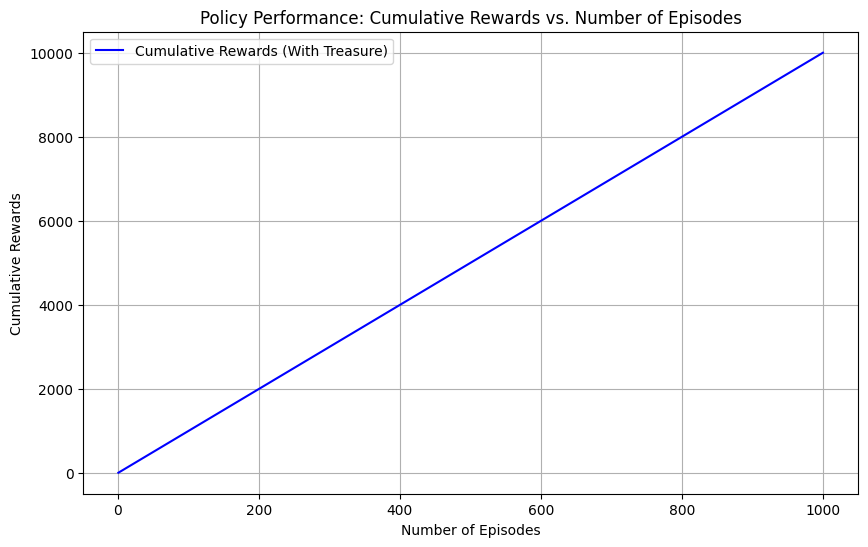

In [29]:
# Main Execution
if __name__ == "__main__":
    main_function()